<a href="https://colab.research.google.com/github/MarcosVeniciu/Kuzushiji-MNIST-classification/blob/main/Arquitetura_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Referencias principais
## Artigo: https://arxiv.org/pdf/1503.03832.pdf
## Código: https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352
## Gerar Triplets: https://omoindrot.github.io/triplet-loss
## Keras triple loss exemplo: https://www.tensorflow.org/addons/tutorials/losses_triplet?hl=pt-br#semihard_online_learning
#
# Referências
## Norma Euclidiana L2: https://medium.com/mlearning-ai/is-l2-norm-euclidean-distance-a9c04be0b3ca
## Face net: https://medium.com/free-code-camp/making-your-own-face-recognition-system-29a8e728107c
## Função de TripletHardLoss: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletHardLoss
## Função de TripletSemiHardLoss: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss
## Triple loss keras:  https://keras.io/examples/vision/siamese_network/ 
## Keras fit e fit_generator: https://acervolima.com/keras-fit-e-keras-fit_generator/
## keras fit, fit_generator e train_on_batch: https://studymachinelearning-com.translate.goog/keras-fit-fit_generator-train_on_batch/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=sc
## Código usando o fit_generator: https://github.com/Ekeany/Siamese-Network-with-Triplet-Loss/blob/master/MachinePart1.ipynb
## explicação axis=-1: https://stackoverflow-com.translate.goog/questions/47435526/what-is-the-meaning-of-axis-1-in-keras-argmax?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=sc
## explicação max pooling: https://www.quora.com/What-is-Max-Pooling-2D

# Dataset 
## Kuzushiji-MNIST -Caracteres de Katakana: https://www.tensorflow.org/datasets/catalog/kmnist?hl=pt-br

In [1]:
!pip install -q -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 8.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import cv2

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Dataset

In [45]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (64, 64))
    return (img, label)

train_dataset, test_dataset = tfds.load(name="kmnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)

train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

train_ds = train_dataset.take(round(len(train_dataset) * 0.8))
val_ds = train_dataset.skip(round(len(train_dataset) * 0.8))

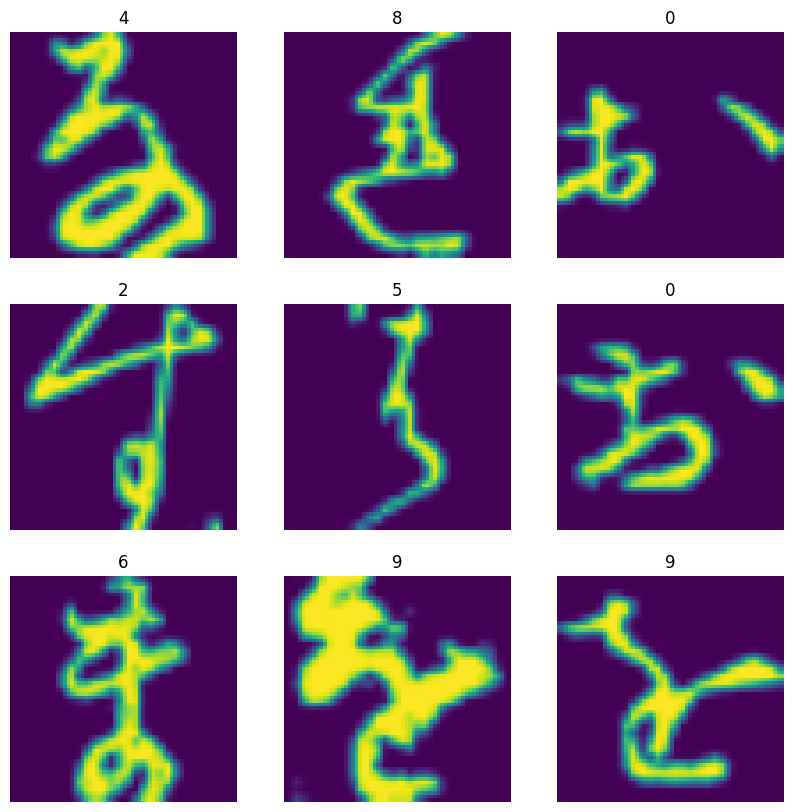

In [46]:
# Visualizar algumas das imagens. Onde o numero acima da imagen indica o indice da classe. 1 para cães e 0 para gatos.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Modelo

In [5]:
# Artigo: https://arxiv.org/pdf/1801.04381.pdf
# Codigo keras: https://github.com/keras-team/keras-applications/blob/06fbeb0f16e1304f239b2296578d1c50b15a983a/keras_applications/mobilenet_v2.py#L425
# Uma explicação sobre a arquitetura: https://machinethink.net/blog/mobilenet-v2/

def _make_divisible(v, divisor, min_value=None): # A mesma coisa do keras
  if min_value is None:
    min_value = divisor
  new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
  # Make sure that round down does not go down by more than 10%.
  if new_v < 0.9 * v:
    new_v += divisor
  return new_v


def bottleneck(inputs, expansion, stride, filters, alpha): # expansion = t, stride = s, filters = c
  x = inputs

  channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
  in_channels = tf.keras.backend.int_shape(inputs)[channel_axis]
  expanded_channel_axis = in_channels * expansion
  
  pointwise_conv_filters = int(filters * alpha)
  pointwise_filters = _make_divisible(pointwise_conv_filters, 8)

  # Expand: 1x1 conv2d , ReLU6 
  # Serve para multiplicar o numero de filtros da entrada por um fator de expansion
  x = layers.Conv2D(expanded_channel_axis, 1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x)

  # Depthwise: 3x3 dwise s=s, ReLU6 (s significa stride) 
  x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x)

  # Project: linear 1x1 conv2d, alpha = 1
  # serve para reverter o processo de expanção
  x = layers.Conv2D(pointwise_filters, 1, padding="same")(x)
  x = layers.BatchNormalization()(x)

  # A conexão residual é usada apenas quando o número de canais que entram no bloco é igual ao número que saem dele e o stride for igual a 1
  if ((in_channels == pointwise_filters) and (stride == 1)): 
   x = layers.Add()([inputs, x])

  return x


def MobileNetV2(input_shape, alpha = 1):
  inputs = keras.Input(shape=input_shape)

  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(inputs)

  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x) # Pode dar problema nesso troço de relu

  # bottleneck 1
  x = bottleneck(inputs= x , expansion= 1, stride= 1, filters= 16, alpha = alpha) # expansion = t, stride = s, filters = c

  # bottleneck 2 e 3
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 24, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 24, alpha = alpha)
  
  # bottleneck 4 
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 32, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 32, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 32, alpha = alpha)

  # bottleneck 7, 8, 9 e 10
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 64, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 64, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 64, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 64, alpha = alpha)

  # bottleneck 11, 12 e 13
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 96, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 96, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 96, alpha = alpha)
 
  # bottleneck 14, 15 e 16
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 160, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 160, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 160, alpha = alpha)

  # bottleneck 17
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 320, alpha = alpha)


  x = layers.Conv2D(1280, 1, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x)

  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = keras.layers.Dense(1280, activation='relu')(x)
  x = keras.layers.Dropout(rate = 0.5, seed = 42)(x) # Regulariza entrada com dropout
  x = keras.layers.Dense(640, activation='relu')(x)
  x = keras.layers.Dropout(rate = 0.5, seed = 42)(x)
  x = layers.Dense(256, kernel_regularizer= tf.keras.regularizers.L2(1e-3))(x)
  output_tensor = layers.Lambda(lambda x: tf.math.l2_normalize(x,axis=-1))(x)

  return tf.keras.Model(inputs, output_tensor, name = "MobileNetV2")

# Treinamento

In [6]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=13, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode = "min", patience = 5, factor=0.5, min_lr=0.0000000001, verbose = 0)
  ]

In [7]:
model = MobileNetV2((64, 64, 1))
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())

In [8]:
!nvidia-smi
historico = model.fit(train_ds, epochs=70, callbacks=my_callbacks, validation_data = val_ds)

Mon May 22 19:11:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    435MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# asdwerfgfgf

In [9]:
model.save("embedding_model_mobilenetV2.h5")

<ipython-input-10-3330d51bfe22>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


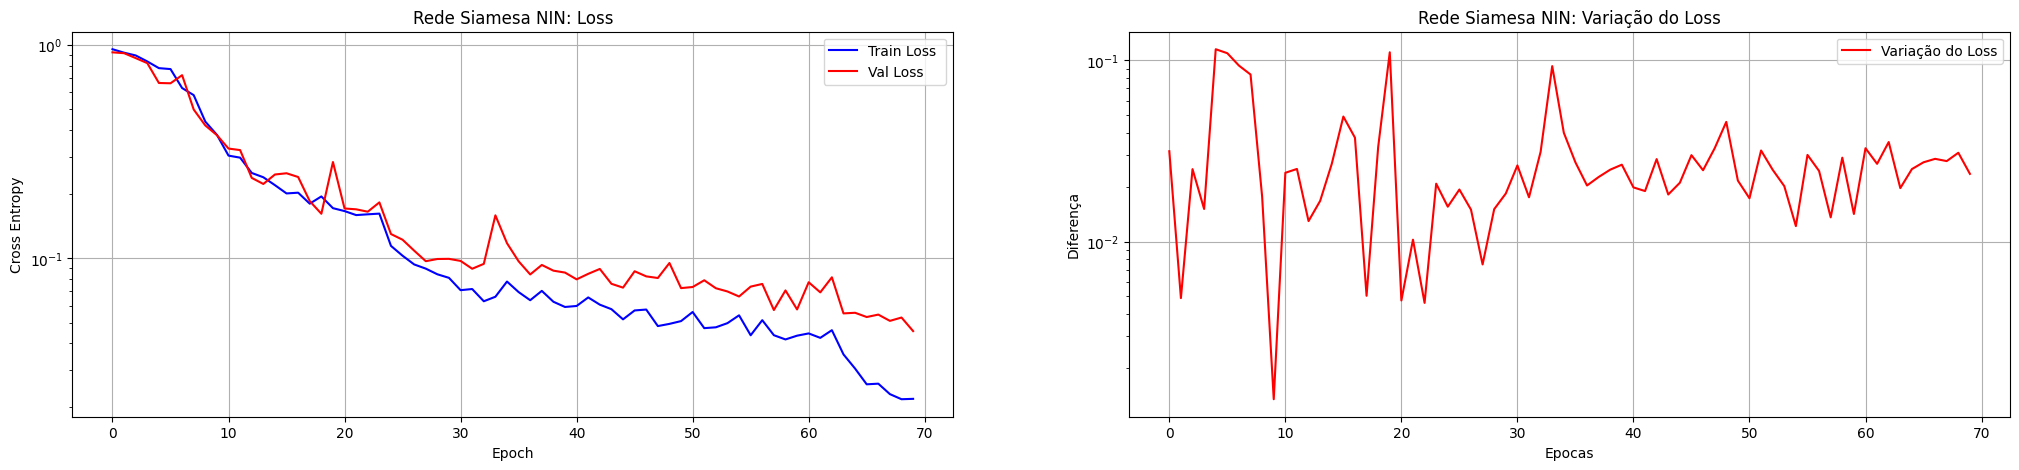

In [10]:
def diferenca(historico):
  accuracy = historico.history['loss'] 
  val_accuracy = historico.history['val_loss']
  vetor_diferenca = []
  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca

  
def grafico(historico, nome): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,2,1)
  plt.title( nome + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.yscale("log")
  plt.plot(historico.history['loss'], label='Train Loss ', color = 'blue')
  plt.plot(historico.history['val_loss'], label='Val Loss ', color = 'red')
  plt.legend()


  # Grafico 3: Diferença de Loss
  vetor_diferenca = diferenca(historico)

  plt.subplot(1,2,2)
  plt.title(nome + ": Variação do Loss")
  plt.xlabel("Epocas")
  plt.ylabel("Diferença")
  plt.grid()
  plt.yscale("log")
  plt.plot(vetor_diferenca, color = 'red', label = 'Variação do Loss')
  plt.legend()

  nome_save = os.path.join("/content", nome + ".jpg")
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()

grafico(historico, "Rede Siamesa NIN")

# Testes

## Funções

In [47]:
nome = ["zero", "um", "dois", "tres", "quatro", "cinco", "seis", "sete", "oito", "nove"]

def prepare_database(model):
  database = {}
  for categoria in range(10):# Busca pra cada uma das 10 categorias
    for img, label in test_dataset: # percorre os lotes do dataset
      for indice in range(len(label)): # percorre os elementos do lote do dataset
        if label[indice] == categoria: # se a categoria do elemento no indice for o mesma da categoria que estou buscando
          identity =  nome[categoria] 
          database[identity] = img_to_encoding(img[indice:indice+1], model)
          break
      if indice != (len(label)-1): break
  return database

In [12]:
def recognise_class(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        #print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

def recognise_class_2(image, database, model):# A diferença dessa pra outra é que ela mostra a distancia
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = tf.math.reduce_euclidean_norm(db_enc - encoding, axis = -1).numpy()[0] # Exemplo ne normalização euclidiana com tensorflow
        print('distance for %s is %s' %(name, dist)) # seria muito ruim ficar mostrando isso para um dataset de 10.000 imagens
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

In [13]:
def img_to_encoding(img, model):
  embedding = model.predict(img, verbose=0)
  return embedding

In [14]:
def metricas(saida):
  certo = 0
  errado = 0
  incerto = 0
  
  for resposta in saida:
    if resposta[1] == nome[resposta[0]]:
      certo += 1
    else:
      if resposta[1] == "can't recognise.":
        incerto += 1
      else:
        if resposta[1] != nome[resposta[0]]:
          errado += 1
  print()
  print("Total de imagem: {0}    Certas: {1}   Erradas: {2}   Incertas: {3}".format(len(saida), certo, errado, incerto))

In [26]:
def img_show(img):
  plt.figure(figsize=(4, 4))
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.axis("off")

## Testes

In [15]:
model = tf.keras.models.load_model("/content/embedding_model_mobilenetV2.h5")

In [48]:
database = prepare_database(model)
saida = []

for img, label in tqdm (test_dataset, desc="Testando..."):
  for i in range(len(img)):
    classe = recognise_class(img[i:i+1], database, model)
    #print("id {2}:: Classe Real: {0} >> Classe Prevista: {1}".format(label[i], classe, i))
    saida.append([label[i], classe])

metricas(saida)

Testando...: 100%|██████████| 313/313 [11:21<00:00,  2.18s/it]



Total de imagem: 10000    Certas: 9609   Erradas: 301   Incertas: 90


1 (ki), 2 (su), 7 (ya), 6 (ma), 8 (re), 9 (wo)

distance for zero is 1.4859893
distance for um is 1.5140193
distance for dois is 1.5251007
distance for tres is 1.474698
distance for quatro is 1.4831935
distance for cinco is 1.4269531
distance for seis is 1.4544079
distance for sete is 1.5246167
distance for oito is 0.0030050534
distance for nove is 1.4949632

Classe Real: 8 >> Classe Prevista: oito


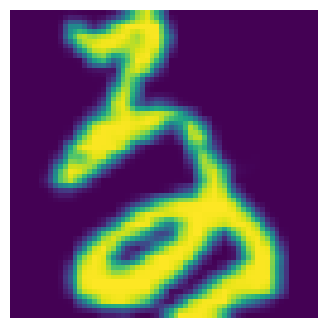

In [49]:
i = 0

print("1 (ki), 2 (su), 7 (ya), 6 (ma), 8 (re), 9 (wo)")
print()
classe = recognise_class_2(img[i:i+1], database, model)
img_show(img[i:i+1])
print()
print("Classe Real: {0} >> Classe Prevista: {1}".format(label[i], classe))